<a href="https://colab.research.google.com/github/ali-rabiee/CartPole-DQN/blob/main/CartPole_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
Cart-pole solution with DQN
'''

In [1]:
# Import libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import copy

In [2]:
env = gym.make("CartPole-v1")

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
n_actions = env.action_space.n
input_dim = env.observation_space.shape[0]

model =nn.Sequential(nn.Linear(input_dim,32),
                     nn.ReLU(),
                     nn.Linear(32,16),
                     nn.ReLU(),
                     nn.Linear(16,n_actions))

model_target = copy.deepcopy(model)
loss_fn = nn.MSELoss()
Learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(),lr= Learning_rate)

In [4]:
def learning(replay_memory,traget_update,minibatch_size=32):

    minibatch = np.random.choice(replay_memory, minibatch_size ,replace=True)
    s = np.array(list(map(lambda x:x['s'], minibatch)))
    a = np.array(list(map(lambda x:x['a'], minibatch)))
    r = np.array(list(map(lambda x:x['r'], minibatch)))
    sprime = np.array(list(map(lambda x:x['sprime'], minibatch)))
    done = np.array(list(map(lambda x:x['done'], minibatch)))

    global model_target

    if traget_update:
      model_target = copy.deepcopy(model)
    q_s = model(torch.tensor(s).float())
    q_sprime = model_target(torch.tensor(sprime).float())
    q_s_target = q_s.detach().clone()

    for i,(s1, a1, r1, q_sprime1, done1) in enumerate(zip(s, a, r, q_sprime, done)):
        if not done1:
          target = r1 + gamma * torch.max(q_sprime1)
        else:
          target = r1
        q_s_target[i][a1] = target

    optimizer.zero_grad()
    loss = loss_fn(q_s ,q_s_target)
    loss.backward()
    optimizer.step()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
n_episodes = 1000
gamma = 0.98
epsilon = 0.9
minibatch_size = 32
r_sums = []
replay_memory = []
mem_max_size = 120000

for n in range(n_episodes):
    s, done, r_sum, flag = env.reset(), False, 0, 1
    while not done:
        q_s = model(torch.tensor(s).float())
        if np.random.random() < epsilon:
            a = env.action_space.sample()
        else:
            a = np.argmax(q_s.detach().numpy())
        sprime,r,done,info = env.step(a)
        r_sum += r
        if len(replay_memory) > mem_max_size:
            replay_memory.pop(0)
        replay_memory.append({"s":s, "a":a, "r":r, "sprime":sprime, "done":done})
        s = sprime
        if n %1 == 0 and flag == 1:
            flag, traget_update = 0, True
        else:
            traget_update = False
        learning(replay_memory, traget_update, minibatch_size=minibatch_size)
    if epsilon > 0.1:
        epsilon -= 0.001
    r_sums.append(r_sum)
    if n % 10 == 0:
        print(f'Episode {n}: {r_sum}')



/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0: 16.0
Episode 10: 10.0
Episode 20: 11.0
Episode 30: 31.0
Episode 40: 26.0
Episode 50: 13.0
Episode 60: 44.0
Episode 70: 39.0
Episode 80: 19.0
Episode 90: 11.0
Episode 100: 18.0
Episode 110: 30.0
Episode 120: 28.0
Episode 130: 90.0
Episode 140: 51.0
Episode 150: 26.0
Episode 160: 25.0
Episode 170: 19.0
Episode 180: 41.0
Episode 190: 25.0
Episode 200: 118.0
Episode 210: 19.0
Episode 220: 31.0
Episode 230: 50.0
Episode 240: 82.0
Episode 250: 20.0
Episode 260: 112.0
Episode 270: 218.0
Episode 280: 173.0
Episode 290: 65.0
Episode 300: 130.0
Episode 310: 58.0
Episode 320: 101.0
Episode 330: 109.0
Episode 340: 211.0
Episode 350: 95.0
Episode 360: 68.0
Episode 370: 104.0
Episode 380: 105.0
Episode 390: 12.0
Episode 400: 184.0
Episode 410: 156.0
Episode 420: 122.0
Episode 430: 22.0
Episode 440: 90.0
Episode 450: 33.0
Episode 460: 38.0
Episode 470: 137.0
Episode 480: 60.0
Episode 490: 68.0
Episode 500: 65.0
Episode 510: 289.0
Episode 520: 157.0
Episode 530: 263.0
Episode 540: 124.0
Epi

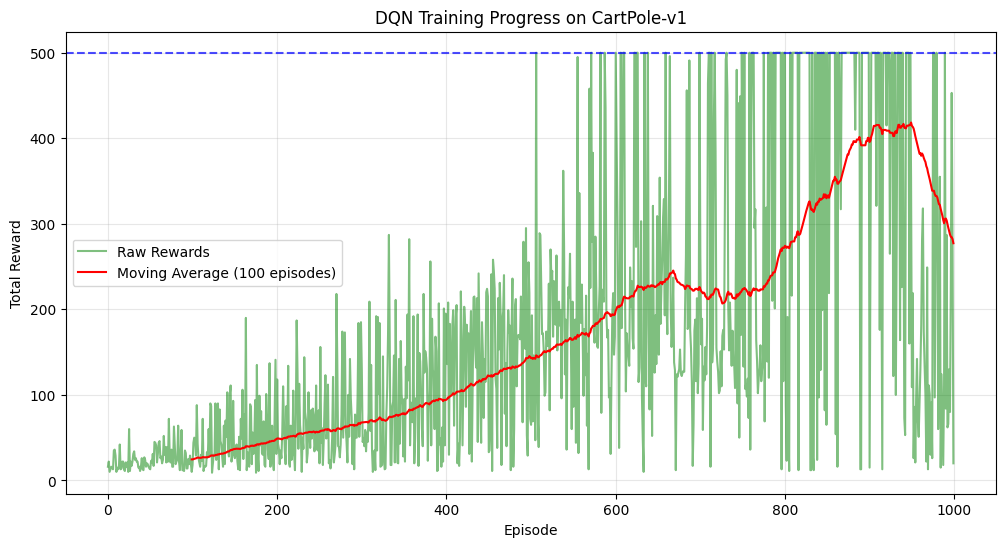

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot_rewards(r_sums, window_size=100):
    plt.figure(figsize=(12, 6))
    plt.plot(r_sums, alpha=0.5, color='g', label='Raw Rewards')

    # Calculate moving average
    moving_avg = np.convolve(r_sums, np.ones(window_size), 'valid') / window_size
    plt.plot(range(window_size-1, len(r_sums)), moving_avg, color='r', label=f'Moving Average ({window_size} episodes)')

    plt.title('DQN Training Progress on CartPole-v1')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add horizontal line at 500 (max possible reward)
    plt.axhline(y=500, color='b', linestyle='--', alpha=0.7, label='Max Reward')

    plt.show()

# Assuming r_sums is your list of episode rewards
plot_rewards(r_sums)

In [15]:
import gym
import torch
import gym
import torch
from gym.wrappers import RecordVideo
import os

def visualize_agent(model, env_name='CartPole-v1', max_steps=500, record=True):
    if record:
        video_folder = "./videos"
        if not os.path.exists(video_folder):
            os.makedirs(video_folder)
        env = gym.make(env_name, render_mode="rgb_array")
        env = RecordVideo(env, video_folder, episode_trigger=lambda x: True)
    else:
        env = gym.make(env_name, render_mode="human")

    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]  # If reset returns a tuple, take the first element
    total_reward = 0

    for t in range(max_steps):
        if not record:
            env.render()
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        action = model(state_tensor).argmax().item()
        next_state, reward, done, truncated = env.step(action)
        state = next_state
        total_reward += reward
        if done or truncated:
            break

    env.close()
    print(f"Episode finished after {t+1} steps. Total reward: {total_reward}")
    if record:
        print(f"Video saved in {video_folder}")

# Use this function to visualize your trained model
visualize_agent(model, record=True)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.b

Episode finished after 331 steps. Total reward: 331.0
Video saved in ./videos
